   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

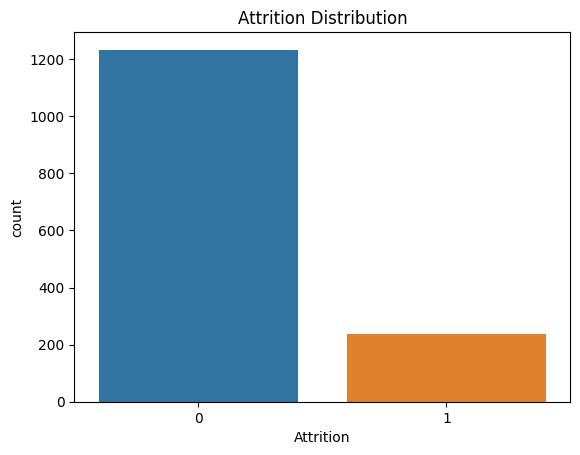

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 986, number of negative: 986
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1406
[LightGBM] [Info] Number of data points in the train set: 1972, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

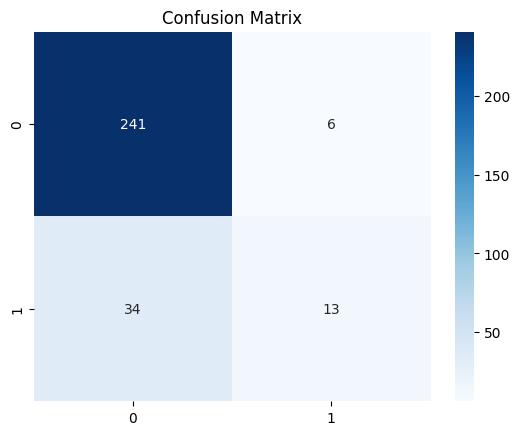

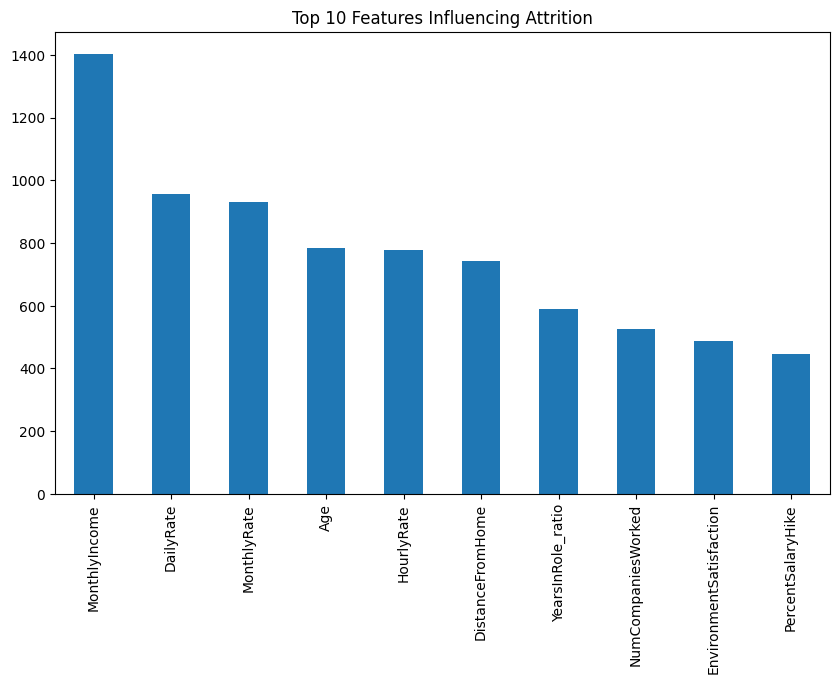

LightGBM model saved successfully!


In [19]:
# Employee Attrition Analysis - LightGBM

# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import joblib

# Step 2: Load Dataset
df = pd.read_csv('HR_Attrition.csv')

# Quick overview
print(df.head())
print(df.info())
print(df.describe())

# Step 3: Preprocessing
# Encode target: Attrition -> 0: No, 1: Yes
df['Attrition'] = df['Attrition'].map({'No': 0, 'Yes': 1})

# Drop irrelevant columns safely
cols_to_drop = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours']
df = df.drop([col for col in cols_to_drop if col in df.columns], axis=1)

# Encode categorical variables
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(df.head())
print(df.columns)

# Step 4: Exploratory Data Analysis (EDA)
# Class distribution
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()



# Step 5: Feature Engineering
# Example interaction feature
df['YearsInRole_ratio'] = df['YearsInCurrentRole'] / (df['YearsAtCompany'] + 1)

# Separate features and target
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Step 6: Train/Test Split & SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to balance classes

# This helps the model learn patterns for the minority class and improve predictions.
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Step 7: Train LightGBM Model
lgb_clf = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    class_weight='balanced',
    random_state=42
)
lgb_clf.fit(X_res, y_res)

# Step 8: Model Evaluation
y_pred = lgb_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 9: Feature Importance
feat_importance = pd.Series(lgb_clf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_importance.head(10).plot(kind='bar')
plt.title("Top 10 Features Influencing Attrition")
plt.show()

# Step 10: Save Model
joblib.dump(lgb_clf, 'attrition_model_lgbm.pkl')
print("LightGBM model saved successfully!")
